In [ ]:
!pip install -U albumentations -q

     |████████████████████████████████| 81kB 3.8MB/s 
     |████████████████████████████████| 37.6MB 122kB/s 
     |████████████████████████████████| 952kB 68.6MB/s 


In [ ]:
!curl -L "https://public.roboflow.com/ds/hfqndxnCdO?key=EeXLiH5OM2" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import albumentations as A
import albumentations.pytorch

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
from PIL import Image
import cv2
from glob import glob

from tqdm.notebook import tqdm, trange

# Download torchvision Object Detection tool

In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 130, done.
remote: Counting objects: 100% (130/130), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 18396 (delta 82), reused 48 (delta 12), pack-reused 18266
Receiving objects: 100% (18396/18396), 17.22 MiB | 15.67 MiB/s, done.
Resolving deltas: 100% (13366/13366), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084 version check against PyTorch's CUDA version


# Convert JSON to DataFrame

In [ ]:
with open(glob('train/*.json')[0], 'r') as f:
    annot_train = json.load(f)
annot_train.keys()

dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])

In [ ]:
annot_train['categories']

[{'id': 0, 'name': 'People', 'supercategory': 'none'},
 {'id': 1, 'name': 'mask', 'supercategory': 'People'},
 {'id': 2, 'name': 'no-mask', 'supercategory': 'People'}]

In [ ]:
annot_train['images'][0]

{'date_captured': '2020-05-11T04:28:59+00:00',
 'file_name': 'thumbnail-ba5c72edb320b49a69e86b05775c49b2-scaled-1_jpeg.rf.035d587add7bc2a6c7616d72e56bfad4.jpg',
 'height': 416,
 'id': 0,
 'license': 1,
 'width': 416}

In [ ]:
annot_train['annotations'][0]

{'area': 336,
 'bbox': [253, 120, 16, 21],
 'category_id': 2,
 'id': 0,
 'image_id': 0,
 'iscrowd': 0,
 'segmentation': []}

In [ ]:
with open(glob('valid/*.json')[0], 'r') as f:
    annot_val = json.load(f)
annot_val.keys()

dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])

# Json to DataFrame

In [ ]:
def make_df_img(items):
    filename_arr, id_arr = [], []
    for item in items:
        filename_arr.append(item['file_name'])
        id_arr.append(item['id'])
    return pd.DataFrame({'filename': filename_arr, 'id': id_arr})

In [ ]:
def make_df_annot(items):
    id_arr, label_arr, bbox_arr, area_arr, iscrowd_arr = [], [], [], [], []
    for idx, item in enumerate(items):
        [x1, y1, w, h] = item['bbox']
        x2 = w + x1
        y2 = h+ y1
        if x2 <= x1:
          print(f"{idx}: {x2} <= {x1} {w} {h}")
          continue
        
        if y2 <= y1:
          print(f'{idx}: {y2} <= {y1} {w} {h}')
          continue

        bbox_arr.append([x1, y1, x2, y2])

        id_arr.append(item['image_id'])
        label_arr.append(item['category_id'])
        area_arr.append(item['area'])
        iscrowd_arr.append(item['iscrowd'])
    return pd.DataFrame({'image_id': id_arr, 'label': label_arr, 'bbox': bbox_arr, 'area': area_arr, 'iscrowd': iscrowd_arr})

In [ ]:
df_img_train = make_df_img(annot_train['images'])
df_img_train['filename'] = 'train/'+df_img_train['filename']
df_img_train.head()

,filename,id
0,train/thumbnail-ba5c72edb320b49a69e86b05775c49...,0
1,train/w1240-p16x9-5f8aa310737f8e0e6c43d95a68a8...,1
2,train/ST_20190917_SPTHAZE_5120715_jpg.rf.09fb2...,2
3,train/1580128422_jpg.rf.182b42586c5d5ea95a75c1...,3
4,train/pollution-mask-CE5HYF_jpg.rf.21d8ab9eb19...,4


In [ ]:
df_img_val = make_df_img(annot_val['images'])
df_img_val['filename'] = 'valid/'+df_img_val['filename']
df_img_val.head()

,filename,id
0,valid/phpM5suKS_jpg.rf.556d78a695ded9fb5f5d184...,0
1,valid/0ad90195-cd77-489e-bf85-08c83b80d3e0_jpg...,1
2,valid/w1240-p16x9-coronavirus_CHINA-HEALTH_jpg...,2
3,valid/15391513321824spp815on8_jpg.rf.0fb7d846a...,3
4,valid/000_1OC3DT_jpg.rf.0570a1f4ab79e324496c31...,4


In [ ]:
df_annot_train = make_df_annot(annot_train['annotations'])
df_annot_train.head()

349: 179 <= 179 0 0


,image_id,label,bbox,area,iscrowd
0,0,2,"[253, 120, 269, 141]",336,0
1,0,1,"[84, 128, 98, 143]",210,0
2,0,1,"[371, 69, 412, 119]",2050,0
3,0,1,"[270, 92, 311, 136]",1804,0
4,0,1,"[203, 87, 242, 131]",1716,0


In [ ]:
df_annot_val = make_df_annot(annot_val['annotations'])
df_annot_val.head()

,image_id,label,bbox,area,iscrowd
0,0,2,"[117, 95, 147, 170]",2250,0
1,0,2,"[75, 85, 124, 178]",4557,0
2,0,1,"[255, 99, 302, 204]",4935,0
3,0,2,"[331, 61, 413, 184]",10086,0
4,0,1,"[0, 19, 96, 170]",14496,0


In [ ]:
df_annot_train.iloc[347:353]

,image_id,label,bbox,area,iscrowd
347,45,1,"[359, 160, 373, 176]",224,0
348,45,1,"[238, 198, 258, 220]",440,0
349,45,1,"[186, 218, 207, 240]",462,0
350,45,1,"[19, 248, 45, 271]",598,0
351,45,1,"[363, 324, 388, 350]",650,0
352,45,1,"[291, 204, 309, 224]",360,0


# Create Torch Dataset

In [ ]:
class ObjDataset(torch.utils.data.Dataset):
    def __init__(self, df_img, df_annot, transforms=None):
        self.filename = df_img['filename'].values
        self.df_annot = df_annot
        self.transforms = transforms
    
    def __len__(self):
        return len(self.filename)
    
    def __getitem__(self, idx):
        image = cv2.imread(self.filename[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        image_id = torch.as_tensor([idx], dtype=torch.int64)
        select_df_annot = self.df_annot[self.df_annot['image_id'] == idx]

        labels = torch.as_tensor(select_df_annot['label'].values, dtype=torch.int64)
        boxes = select_df_annot['bbox'].to_list()
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        area = torch.as_tensor(select_df_annot['area'].values, dtype=torch.float32)
        iscrowd = torch.as_tensor(select_df_annot['iscrowd'].values, dtype=torch.uint8)

        if self.transforms:
            transformed = self.transforms(image=image, bboxes=boxes, class_labels=select_df_annot['label'].values)
            image = transformed['image']
            boxes = torch.as_tensor(transformed['bboxes'], dtype=torch.float32)
            label = transformed['class_labels']

            area = torch.as_tensor([ (box[2]-box[0])*(box[3]-box[1]) for box in boxes ], dtype=torch.float32)

        target = {}
        target['image_id'] = image_id
        target['boxes'] = boxes
        target['area'] = area
        target['iscrowd'] = iscrowd
        target['labels'] = labels
        return image, target

In [ ]:
transform = {
    'train': A.Compose([
        A.ShiftScaleRotate(rotate_limit=45,border_mode=0, p=0.7),
        A.Flip(),
        A.Transpose(),
        A.RandomBrightnessContrast(),
        A.GaussNoise(),
        A.ToGray(p=0.4),
        A.Blur(3),
        A.pytorch.ToTensor(),
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels'])),
    
    'val': A.Compose([
        A.pytorch.ToTensor()
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))
}

In [ ]:
from engine import train_one_epoch, evaluate
from utils import collate_fn

In [ ]:
datagen = ObjDataset(df_img_train, df_annot_train, transform['train'])
dataset = torch.utils.data.DataLoader(datagen, batch_size=16, shuffle=True, pin_memory=True, collate_fn=collate_fn)

datagen_val = ObjDataset(df_img_val, df_annot_val, transform['val'])
dataset_val = torch.utils.data.DataLoader(datagen_val, batch_size=16, shuffle=True, pin_memory=True, collate_fn=collate_fn)

# Plotting Bouding Box

In [ ]:
from matplotlib.patches import Rectangle

def draw_bbox(xmin, ymin, xmax, ymax):
  plt.gca().add_patch(Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, lw=1, ls='-', color='red', fc='None'))

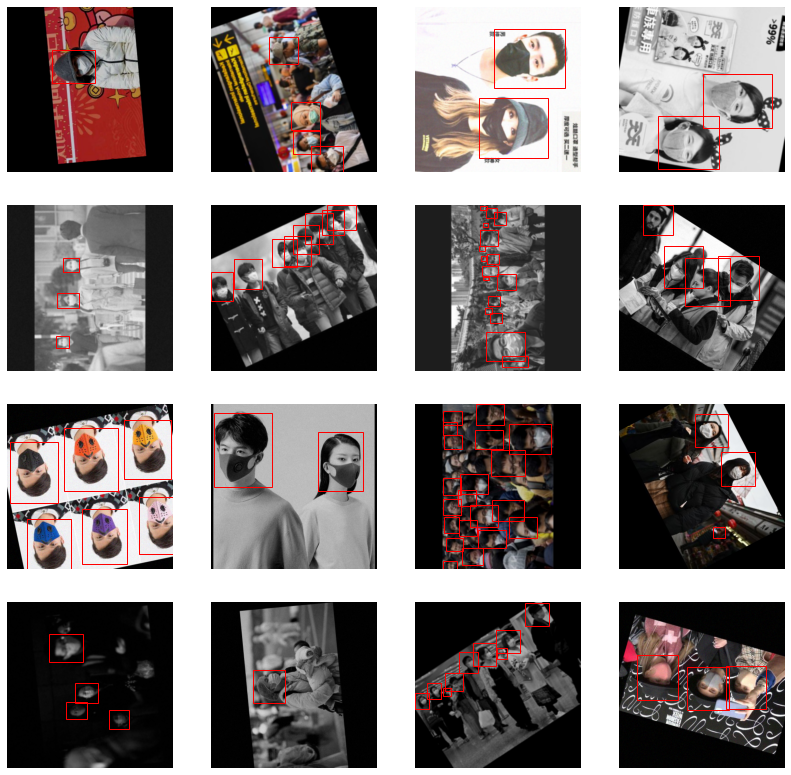

In [ ]:
plt.figure(figsize=(14, 14))
img, tar = next(iter(dataset))

for i in range(1, 17):
  plt.subplot(4, 4, i)
  plt.imshow(img[i-1].permute(1, 2, 0))
  for box in tar[i-1]['boxes']: draw_bbox(*box)
  plt.axis('off')
plt.show()

tensor(0.) tensor(1.)


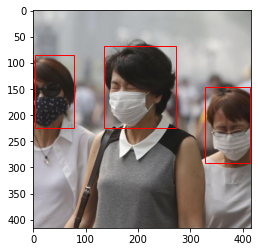

In [ ]:
for img, tar in dataset_val:
    image = img[0]
    print(image.min(), image.max())
    plt.imshow(image.permute(1, 2, 0))
    for box in tar[0]['boxes']:
        draw_bbox(*box)
    plt.show()
    break

# Pretrained Faster RCNN

In [ ]:
"""from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
 
# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, trainable_backbone_layers=0)
 
# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 3  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

model"""

'from torchvision.models.detection.faster_rcnn import FastRCNNPredictor\n \n# load a model pre-trained pre-trained on COCO\nmodel = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, trainable_backbone_layers=0)\n \n# replace the classifier with a new one, that has\n# num_classes which is user-defined\nnum_classes = 3  # 1 class (person) + background\n# get number of input features for the classifier\nin_features = model.roi_heads.box_predictor.cls_score.in_features\n# replace the pre-trained head with a new one\nmodel.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) \n\nmodel'

# Retraining

In [ ]:
!pip install timm -U -q
!pip install nfnets-pytorch -q

In [ ]:
import timm
from timm.models.nfnet import dm_nfnet_f6
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

backbone = timm.models.efficientnet_b3a(pretrained=True)

class Identity(nn.Module):
  def __init__(self):
    super(Identity, self).__init__()
  def forward(self, x):
    return x

backbone.classifier = Identity()
backbone.global_pool = Identity()
backbone.out_channels = 1536

anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=["0", "1", "2", "3"], output_size=8, sampling_ratio=2)

model = FasterRCNN(backbone, num_classes=3,
        rpn_anchor_generator=anchor_generator, box_roi_pool=roi_pooler,
        min_size = 450, max_size = 450
)

# Compile Model

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

model = model.to(device)

cuda


In [ ]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-b6665b09-881b-0601-4a51-6d0f522f19d2)


In [ ]:
for p in model.backbone.parameters():
  p.requires_grad = False
  #print(p.requires_grad)

In [ ]:
print(len([p for p in model.parameters()]))

params = [p for p in model.parameters() if p.requires_grad]

print(len(params))

#from nfnets import WSConv2d, SGD_AGC
#optim_agc = SGD_AGC(model.parameters(), 1e-3, momentum=0.9, weight_decay=2e-5)

#optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=2e-5)
optimizer = torch.optim.Adam(params, lr=0.001)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

352
14


# Training

In [ ]:
for epoch in trange(1, 101):
  train_one_epoch(model, optimizer, dataset, device, epoch, print_freq=10)
  lr_scheduler.step()
  with torch.no_grad():
    #cpu_device = torch.device('cpu')
    evaluate(model, dataset_val, device=device)

Epoch: [1]  [0/7]  eta: 0:00:07  lr: 0.001000  loss: 1.9760 (1.9760)  loss_classifier: 1.1009 (1.1009)  loss_box_reg: 0.0559 (0.0559)  loss_objectness: 0.7236 (0.7236)  loss_rpn_box_reg: 0.0956 (0.0956)  time: 1.1174  data: 0.3376  max mem: 4156
Epoch: [1]  [6/7]  eta: 0:00:01  lr: 0.001000  loss: 3.5406 (4.4407)  loss_classifier: 1.4264 (2.8413)  loss_box_reg: 0.9768 (1.1349)  loss_objectness: 0.1667 (0.3174)  loss_rpn_box_reg: 0.1542 (0.1471)  time: 1.0417  data: 0.3261  max mem: 5561
Epoch: [1] Total time: 0:00:07 (1.0420 s / it)
creating index...
index created!
Test:  [0/2]  eta: 0:00:01  model_time: 0.6447 (0.6447)  evaluator_time: 0.0135 (0.0135)  time: 0.7430  data: 0.0802  max mem: 6729
Test:  [1/2]  eta: 0:00:00  model_time: 0.5361 (0.5904)  evaluator_time: 0.0135 (0.0176)  time: 0.6851  data: 0.0729  max mem: 6729
Test: Total time: 0:00:01 (0.6856 s / it)
Averaged stats: model_time: 0.5361 (0.5904)  evaluator_time: 0.0135 (0.0176)
Accumulating evaluation results...
DONE (t=0.

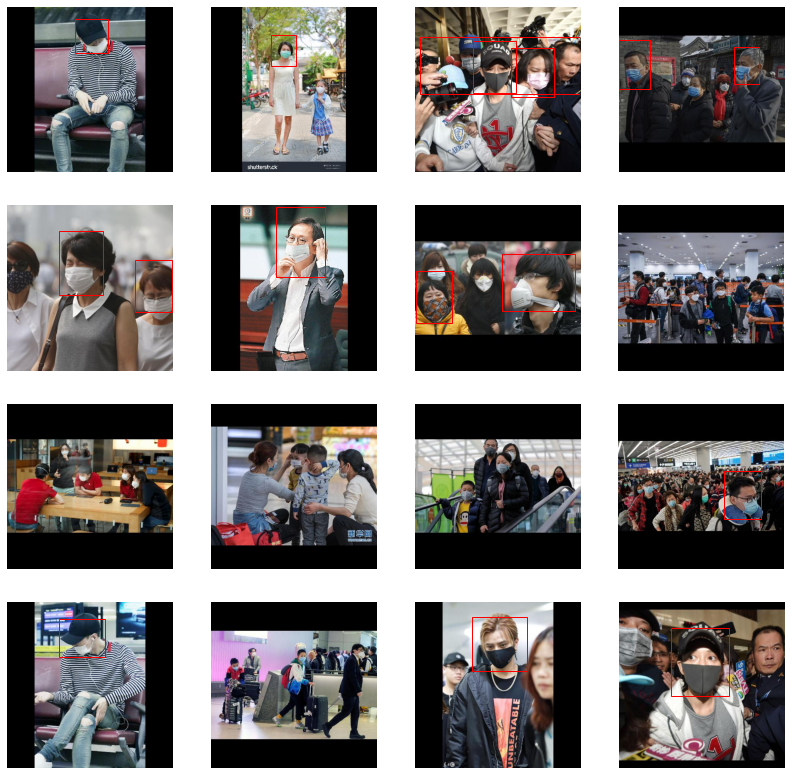

In [ ]:
model.to(device)
model.eval()
plt.figure(figsize=(14, 14))
with torch.no_grad():
  img, tar = next(iter(dataset_val))
  out = model([ item.to(device) for item in img])

for i in range(1, 17):
  plt.subplot(4, 4, i)
  plt.imshow(img[i-1].permute(1, 2, 0))
  for j in range(len(out[i-1]['scores'])):
    if out[i-1]['scores'][j] > 0.8: draw_bbox(*out[i-1]['boxes'][j])
  plt.axis('off')
plt.show()

In [ ]:
from time import time

model.eval()

with torch.no_grad():
  img, tar = next(iter(dataset_val))
  s = time()
  out = model.to(torch.device('cpu'))([img[0].to(torch.device('cpu'))])
  print(time()-s)

2.834455966949463
